In [1]:
from utils import generate_data, visualize_data, plot_true_vs_pred, plot_loss_surface, train_test_split, create_polynomial_features

In [2]:
import torch

# Create single-element tensors with requires_grad=True for gradient tracking
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)

# Perform an operation: c = a * b + a^2
c = a * b + a**2

# Compute gradients with respect to a and b
c.backward()

# Inspect gradients
print(f"Gradient of c w.r.t. a: {a.grad}")  # Output: tensor(7.)  (since dc/da = b + 2a = 3 + 4 = 7)
print(f"Gradient of c w.r.t. b: {b.grad}")  # Output: tensor(2.)  (since dc/db = a = 2)

Gradient of c w.r.t. a: 7.0
Gradient of c w.r.t. b: 2.0


In [3]:
X, y = generate_data()

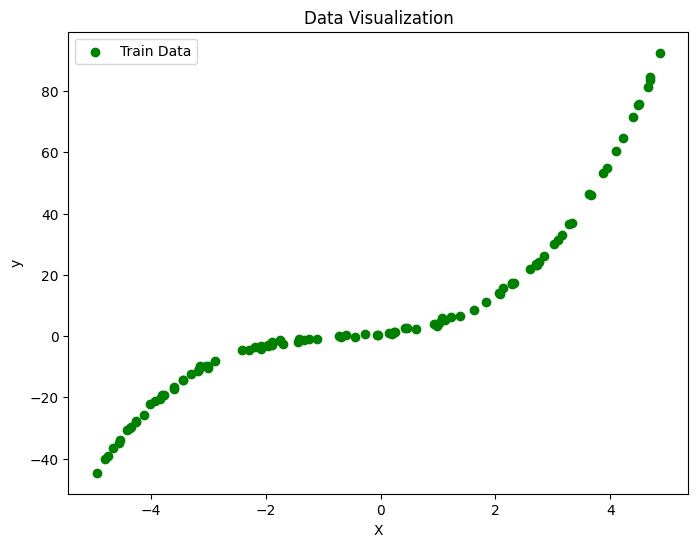

In [4]:
visualize_data(X, y)

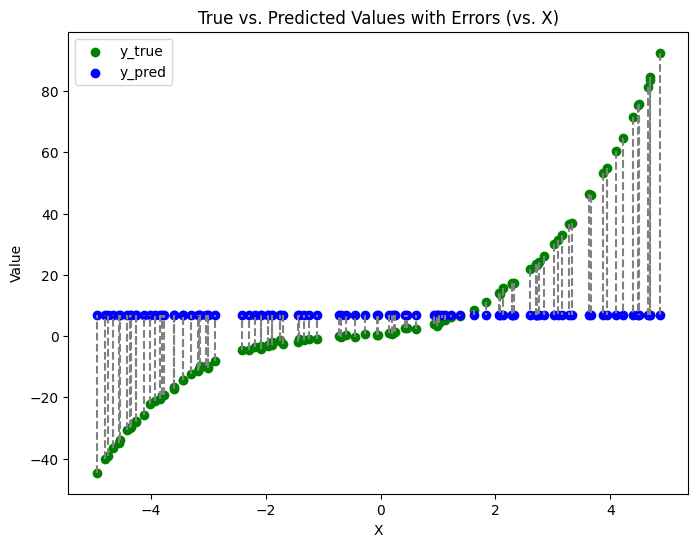

In [5]:
mean_y = torch.mean(y)
y_pred_mean = torch.full_like(y, mean_y)

# Visualize (now passes X)
plot_true_vs_pred(X, y, y_pred_mean)

In [6]:
import torch.nn as nn

criterion = nn.MSELoss()
mse_mean = criterion(y, y_pred_mean)  # Both are Torch tensors
print(f"MSE for Mean Model: {mse_mean.item():.4f}")

MSE for Mean Model: 882.2477


In [7]:
torch.sqrt(mse_mean)

tensor(29.7027)

In [8]:
# Define a linear layer: input size 1 (for single-variable), output size 1
linear = nn.Linear(in_features=1, out_features=1)

# Inspect weights and biases
print("Initial Weight:", linear.weight)  
print("Initial Bias:", linear.bias)

# Manually set weights and biases
linear.weight.data = torch.tensor([[3.0]])
linear.bias.data = torch.tensor([1.0])
print("Updated Weight:", linear.weight)
print("Updated Bias:", linear.bias)

Initial Weight: Parameter containing:
tensor([[-0.9755]], requires_grad=True)
Initial Bias: Parameter containing:
tensor([-0.5040], requires_grad=True)
Updated Weight: Parameter containing:
tensor([[3.]], requires_grad=True)
Updated Bias: Parameter containing:
tensor([1.], requires_grad=True)


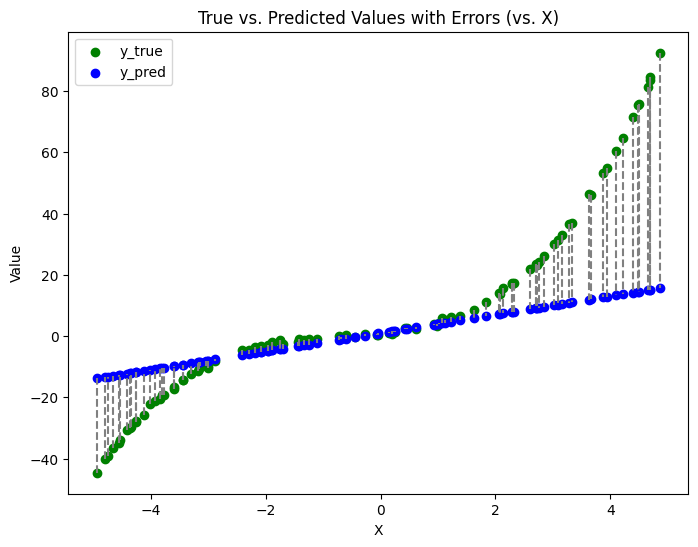

MSE for Hand-Set Linear Model: 519.9346


In [9]:
# Reshape X to 2D for PyTorch (n_samples, 1)
X_reshaped = X.unsqueeze(1)  # Torch operation

# Predict
y_pred_linear = linear(X_reshaped).squeeze()  # Squeeze to 1D tensor

# Visualize (passes X) and compute MSE
plot_true_vs_pred(X, y, y_pred_linear)
mse_linear = criterion(y, y_pred_linear)
print(f"MSE for Hand-Set Linear Model: {mse_linear.item():.4f}")

Updated Weight: Parameter containing:
tensor([[1.7292]], requires_grad=True)
Updated Bias: Parameter containing:
tensor([1.0262], requires_grad=True)


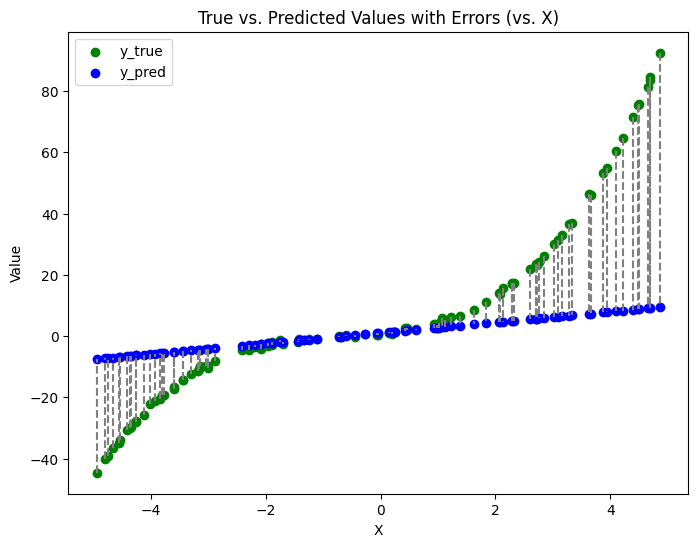

New MSE after Manual Update: 667.7316


In [10]:
# Reset linear layer for demonstration
linear = nn.Linear(1, 1)

# Forward pass
y_pred = linear(X_reshaped).squeeze()

# Compute loss (y reshaped to match)
loss = criterion(y_pred, y)

# Backward pass
loss.backward()

# Manual update (instead of optimizer.step())
with torch.no_grad():
    linear.weight -= 0.01 * linear.weight.grad
    linear.bias -= 0.01 * linear.bias.grad
    linear.weight.grad.zero_()  # Clear gradients
    linear.bias.grad.zero_()

# Show changes
print("Updated Weight:", linear.weight)
print("Updated Bias:", linear.bias)

# New prediction
y_pred_new = linear(X_reshaped).squeeze()

# Visualize (passes X) and compute new MSE
plot_true_vs_pred(X, y, y_pred_new)
mse_new = criterion(y, y_pred_new)
print(f"New MSE after Manual Update: {mse_new.item():.4f}")

/workspaces/bestgliwice-mlcourse/.venv/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


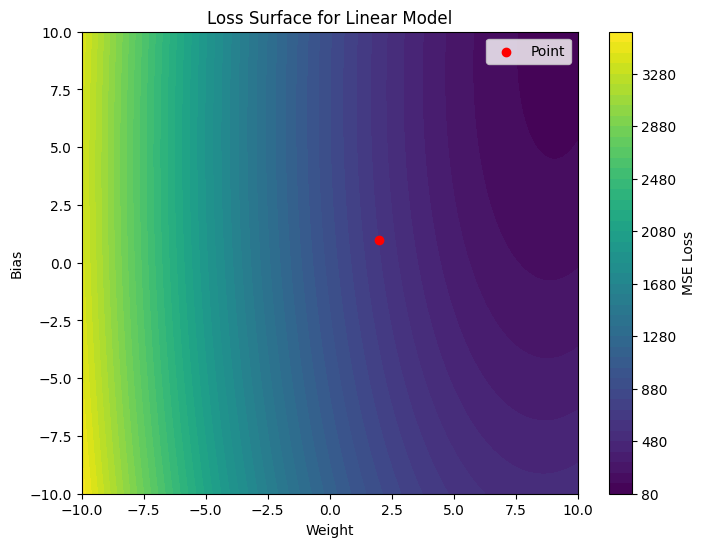

In [11]:
plot_loss_surface(X, y, 2.0, 1.0)  # Mark point (weight=2.0, bias=1.0)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, seed=42)

Train MSE: 147.8732, Test MSE: 90.3286


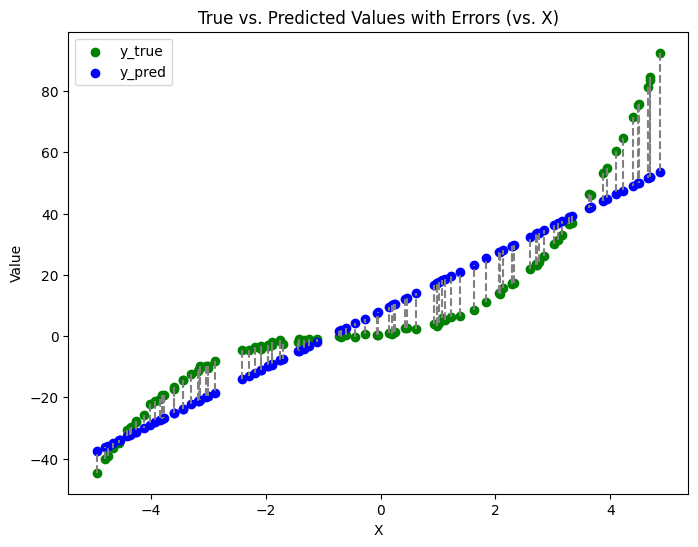

In [13]:
X_train_reshaped = X_train.unsqueeze(1)
X_test_reshaped = X_test.unsqueeze(1)

# Model and optimizer
model = nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train for 100 epochs
for epoch in range(100):
    optimizer.zero_grad()
    y_pred_train = model(X_train_reshaped).squeeze()
    loss = criterion(y_pred_train, y_train)
    loss.backward()
    optimizer.step()

# Evaluate
y_pred_train = model(X_train_reshaped).squeeze()
y_pred_test = model(X_test_reshaped).squeeze()

train_mse = criterion(y_pred_train, y_train).item()
test_mse = criterion(y_pred_test, y_test).item()
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

# Visualize predictions on full data for illustration (passes X)
y_pred_full = model(X.unsqueeze(1)).squeeze()
plot_true_vs_pred(X, y, y_pred_full)

In [18]:
degree = 3
X_train_poly = create_polynomial_features(X_train, degree)
X_test_poly = create_polynomial_features(X_test, degree)

mean, std = X_train_poly.mean(), X_train_poly.std()


X_train_poly = (X_train_poly - mean ) / std
X_test_poly = (X_test_poly - mean ) / std

model_poly = nn.Linear(degree, 1)
optimizer_poly = torch.optim.SGD(model_poly.parameters(), lr=0.01)

for epoch in range(100):
    optimizer_poly.zero_grad()
    y_pred_train_poly = model_poly(X_train_poly).squeeze()
    loss_poly = criterion(y_pred_train_poly, y_train)
    loss_poly.backward()
    optimizer_poly.step()

# Compute errors (repeat for each degree)
y_pred_train_poly_eval = model_poly(X_train_poly).squeeze()
y_pred_test_poly = model_poly(X_test_poly).squeeze()
train_mse_poly = criterion(y_pred_train_poly_eval, y_train).item()
test_mse_poly = criterion(y_pred_test_poly, y_test).item()
print(f"Degree {degree}: Train MSE: {train_mse_poly:.4f}, Test MSE: {test_mse_poly:.4f}")

Degree 3: Train MSE: 44.8730, Test MSE: 46.6046


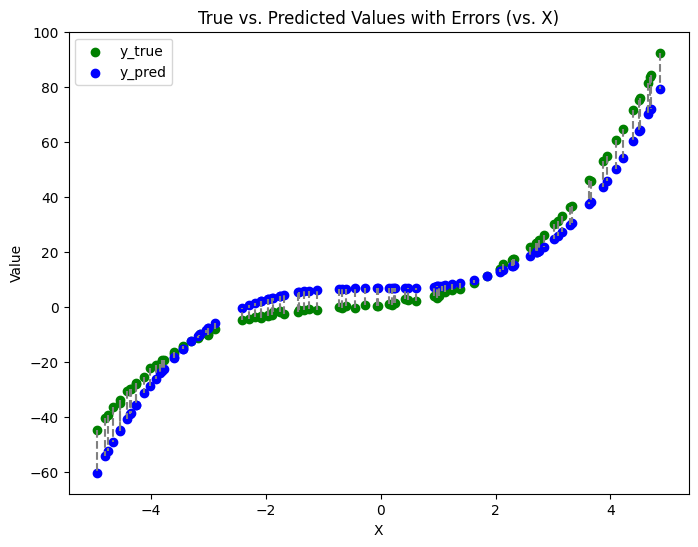

In [19]:
X_poly = create_polynomial_features(X, degree)
X_poly = (X_poly - mean ) / std


y_pred_full = model_poly(X_poly).squeeze()
plot_true_vs_pred(X, y, y_pred_full)